In [3]:
import itertools
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import pickle
import random
from sklearn.model_selection import train_test_split
import time
from joblib import Parallel, delayed
import pandas as pd
import sys
import os
import seaborn as sns 
from sklearn.metrics import r2_score
import math
import matplotlib as mpl
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances
import scipy

from cryptic_rnn import *

In [12]:
from matplotlib.lines import Line2D
colors2 = ['green', 'blue', 'orange', 'red']*4
colors1 = ['green']*4 + ['blue']*4 + ['orange']*4 + [ 'red']*4
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=5, label='A + _'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=5, label='B + _'), 
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=5, label='C + _'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=5, label='D + _'),
                   Line2D([0], [0], marker='o', color='w', markeredgecolor = 'green', markerfacecolor='none', markersize=10, label=' _ + A'),
                   Line2D([0], [0], marker='o', color='w', markeredgecolor = 'blue',markerfacecolor='none', markersize=10, label=' _ + B'), 
                   Line2D([0], [0], marker='o', color='w', markeredgecolor = 'orange',markerfacecolor='none', markersize=10, label=' _ + C'),
                   Line2D([0], [0], marker='o', color='w', markeredgecolor = 'red',markerfacecolor='none', markersize=10, label=' _ + D')]


In [6]:
# data
num_classes = 22
batchsize=1

# RNN specs
input_size = num_classes
output_size = 1
num_layers = 1
hidden_size = 20
learningRate = 0.005

## running params
epochs = 1200
num_sims = 104

ops = '+'

num_inputs = 4
total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
all_syms = total_syms[:num_inputs]
all_input_vals = list(np.arange(2,18))
input_vals = random.sample(all_input_vals,num_inputs)
input_vals.sort()
# randomly select values for each input
cue_dict = {}
for i, s in enumerate(all_syms):
    cue_dict[s] = input_vals[i]
    
print(cue_dict)
primitives = generate_primitives(all_syms, cue_dict)
rp = generate_other_reverse_primitives('+', all_syms, cue_dict)
print(primitives)
print(rp)
testseqs = generate_trials(ops, all_syms, all_syms, cue_dict)

{'A': 5, 'B': 7, 'C': 12, 'D': 15}
[['A', '=', 5], ['B', '=', 7], ['C', '=', 12], ['D', '=', 15]]
[['A', ('+', 'C'), '=', 17], ['B', ('+', 'D'), '=', 22]]


In [90]:
## running function
def get_reps(model, testdata, hidden_size):
    model.eval()
    trials = []
    hiddens = []
    for testset in testdata:
        for x,y in testset:
            for i in range(len(x)):
                hidden_arr = np.empty((0,  hidden_size))
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                    hidden_arr = np.vstack([hidden_arr, hidden.detach().numpy()])
            hiddens.append(hidden_arr)
            trials.append(str(onehot2seq(x)))

    return hiddens, trials 


## calculate distance matrices for all models and steps 

def calculate_RDMs(res):
    ## find indices of 100% acc rnns
    acc_df = res['acc_df']
    #all_acc_mods = acc_df.index
    all_acc_mods = acc_df[(acc_df['acc_train'] == 1) & (acc_df['acc_train_p'] == 1)].index
    #all_acc_mods = acc_df[(acc_df['acc_train_rp'] == 1) & (acc_df['acc_train_p'] == 1)].index
    #all_acc_mods = acc_df[(acc_df['acc_train'] == 1) & (acc_df['acc_train_p'] == 1)& (acc_df['acc_train_rp'] == 1)].index
    print('no. 100% trained RNNs: ', len(all_acc_mods))

    mod_list = all_acc_mods # choose only rnns trained to 100%
    # mod_list = np.arange(num_sims)

    # initialise empty lists/arrays
    rdms = [[] for _ in range(4)]
    rdms_rp = [[] for _ in range(4)]
    rdms_p = [[] for _ in range(4)]

    # extracts results from dictionary
    mods = res['mods']
    mods_rp = res['mods_rp']
    mods_p = res['mods_p']
    cue_dicts = res['cue_dicts']
    testseq = generate_trials(ops, all_syms, all_syms, cue_dict)
    ft_cue_dicts = [cue_dicts[j] for j in mod_list]

    for ind, m in enumerate(mod_list): # for each model 
        
        testseqs = change_dict(testseq, cue_dicts[m])
        train_inputs = convert_seq2inputs(testseq, num_classes=num_classes, seq_len=5)
        testset = DataLoader(train_inputs, batch_size=batchsize, shuffle=False)
        
        # get activations for control model
        hiddens, trials = get_reps(mods[m], [testset], hidden_size)
        for h in range(4): 
            hid_vals = np.array([hid[h,:] for hid in hiddens]) # combine activations from each trial for the time step
            rep_mat = euclidean_distances(hid_vals) # calculate euclidean distance matrix between trials
            rdms[h].append(rep_mat)
            
        # get activations for primitive trained model
        hiddens_rp, trials = get_reps(mods_rp[m], [testset], hidden_size)    
        for h in range(4):
            hid_vals = np.array([hid[h,:] for hid in hiddens_rp])
            rep_mat = euclidean_distances(hid_vals)
            rdms_rp[h].append(rep_mat)
        
        # get activations for primitive trained model
        hiddens_p, trials = get_reps(mods_p[m], [testset], hidden_size)    
        for h in range(4):
            hid_vals = np.array([hid[h,:] for hid in hiddens_p])
            rep_mat = euclidean_distances(hid_vals)
            rdms_p[h].append(rep_mat)
            
    return {'rdms': rdms, 'rdms_rp': rdms_rp,'rdms_p': rdms_p, 'ft_cue_dicts': ft_cue_dicts}

# for ranked control
rank_dict = {'A': -1.5, 'B': -0.5, 'C': 0.5, 'D': 1.5}

# for selecting untrained trials
rp = generate_other(ops, all_syms, cue_dict) + generate_other_reverse_primitives('+', all_syms, cue_dict)
valset = [t for t in testseqs if t not in rp]
valset_idx = [testseqs.index(val) for val in valset]

def regress_RDM_abs(time_step, rdm, ft_cue_dicts, ranked = False):
    rs = []
    for i, cuedict in enumerate(ft_cue_dicts):
        if ranked:
            curr_tests = change_dict(testseqs, rank_dict)
        else:
            curr_tests = change_dict(testseqs, cuedict)
        truth_outs = [t[-1] for t in curr_tests]
        truth_RDM = abs(np.array([truth_outs]*16) - np.array([truth_outs]*16).T)
        x = []
        y = []
        for p in valset_idx:
            for q in valset_idx:
                x.append(rdm[time_step][i][p,q])
                y.append(truth_RDM[p,q])
        x = np.array(x).reshape(-1,1)
        y = np.array(y)
        model = LinearRegression().fit(x, y)
        r_sq = model.score(x, y)
        rs.append(r_sq)
    return rs


In [113]:
# read data

save_dir = '../results/representation_analysis/'

with open(save_dir+'res_all_lazy', 'rb') as f:
    res1 = pickle.load(f)

In [114]:
res = calculate_RDMs(res1)
rdms = res['rdms']
rdms_rp = res['rdms_rp']
rdms_p = res['rdms_p']
cue_dicts = res['ft_cue_dicts']

matlist = [np.array(rdms[t]).mean(axis=0) for t in range(4)]
matlist_rp = [np.array(rdms_rp[t]).mean(axis=0) for t in range(4)]
matlist_p = [np.array(rdms_p[t]).mean(axis=0) for t in range(4)]


no. 100% trained RNNs:  735


In [115]:
# find indices of untrained trials
rp = generate_other(ops, all_syms, cue_dict) + generate_primitives(all_syms, cue_dict)
valset = [t for t in testseqs if t not in rp]
valset_idx = [testseqs.index(val) for val in valset]

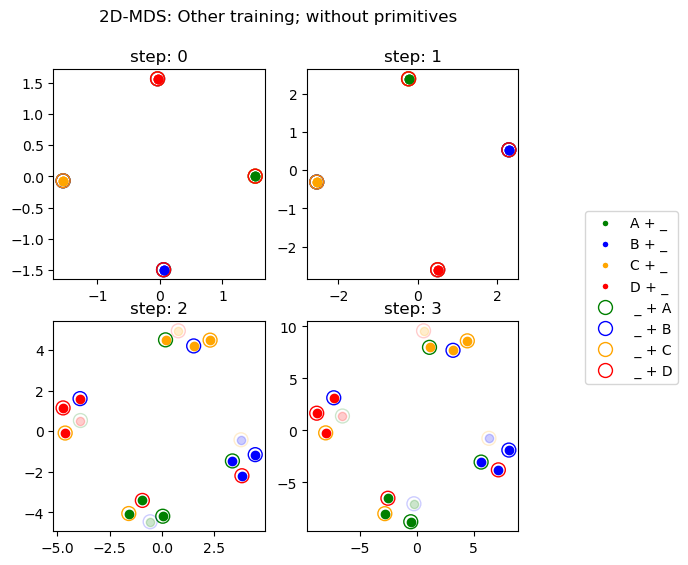

In [116]:
plt.rcParams['figure.figsize'] = 6, 6
fig, axs = plt.subplots(2,2)

#matlist = [rdms[t][m] for t in range(4)]
for j, dist in enumerate(matlist_p):
    mds = MDS(dissimilarity='precomputed',random_state=0, n_components=2)
    X_transform = mds.fit_transform(dist)
    ax = axs[math.floor(j/2), j%2]
    ax.title.set_text('step: '+str(j))
    for i in range(len(testseqs)):
        if i in valset_idx:
            alph = 1
        else:
            alph = 0.2
        ax.scatter(X_transform[i,0], X_transform[i,1], color = colors1[i], alpha = alph)
        ax.scatter(X_transform[i,0], X_transform[i,1], s=100, facecolors='none', edgecolors=colors2[i], alpha = alph)

plt.suptitle('2D-MDS: Other training; without primitives')

fig.legend(handles=legend_elements,  loc='center left', bbox_to_anchor=(1, 0.5))

In [117]:
m = matlist[3]

In [118]:
syms = ['A', 'B', 'C', 'D']
augends = list(range(4))
addends = list(itertools.combinations(augends, 2))

pses = []
nm=[]
for addnd in addends:
    ps_scores = []
    for aug in augends:
        print(syms[aug],'+', syms[addnd[0]], '/', syms[addnd[1]])
        nm.append(str(syms[aug])+'+'+ str(syms[addnd[0]])+ '/'+ str(syms[addnd[1]]))
        u = m[:, aug + addnd[0]]
        v = m[:, aug + addnd[1]]
        ps = np.dot(u,v)/np.linalg.norm(u)/np.linalg.norm(v)
        print('ps: ', ps)
        ps_scores.append(ps)
    pses.append(ps_scores)

A + A / B
ps:  0.9928655052694213
B + A / B
ps:  0.9927934053004562
C + A / B
ps:  0.9931459513459965
D + A / B
ps:  0.798087468260473
A + A / C
ps:  0.9932408606006538
B + A / C
ps:  0.992971668241829
C + A / C
ps:  0.7966652391845286
D + A / C
ps:  0.7938838422525268
A + A / D
ps:  0.9932807629927753
B + A / D
ps:  0.8021418778022952
C + A / D
ps:  0.7924866963089782
D + A / D
ps:  0.796237342028381
A + B / C
ps:  0.9927934053004562
B + B / C
ps:  0.9931459513459965
C + B / C
ps:  0.798087468260473
D + B / C
ps:  0.9930084982315682
A + B / D
ps:  0.992971668241829
B + B / D
ps:  0.7966652391845286
C + B / D
ps:  0.7938838422525268
D + B / D
ps:  0.9929849216656986
A + C / D
ps:  0.9931459513459965
B + C / D
ps:  0.798087468260473
C + C / D
ps:  0.9930084982315682
D + C / D
ps:  0.9931169372409234


In [46]:
m = matlist_p[2]

In [95]:
syms = ['A', 'B', 'C', 'D']
augends = list(range(4))
addends = list(itertools.combinations(augends, 2))

pses = []
nm=[]
for addnd in addends:
    ps_scores = []
    for aug in augends:
        print(syms[aug],'+', syms[addnd[0]], '/', syms[addnd[1]])
        nm.append(str(syms[aug])+'+'+ str(syms[addnd[0]])+ '/'+ str(syms[addnd[1]]))
        u = m[:, aug + addnd[0]]
        v = m[:, aug + addnd[1]]
        ps = np.dot(u,v)/np.linalg.norm(u)/np.linalg.norm(v)
        print('ps: ', ps)
        ps_scores.append(ps)
    pses.append(ps_scores)

A + A / B
ps:  0.9934293503359111
B + A / B
ps:  0.9707145691521597
C + A / B
ps:  0.9256227108680652
D + A / B
ps:  0.8538425660876441
A + A / C
ps:  0.9560156439550598
B + A / C
ps:  0.8539708231724589
C + A / C
ps:  0.9708538422205952
D + A / C
ps:  0.8975922387674539
A + A / D
ps:  0.8497896915369432
B + A / D
ps:  0.9975486485719282
C + A / D
ps:  0.987785808231387
D + A / D
ps:  0.972268711529993
A + B / C
ps:  0.9707145691521597
B + B / C
ps:  0.9256227108680652
C + B / C
ps:  0.8538425660876441
D + B / C
ps:  0.9854122839278796
A + B / D
ps:  0.8539708231724589
B + B / D
ps:  0.9708538422205952
C + B / D
ps:  0.8975922387674539
D + B / D
ps:  0.8864939854893943
A + C / D
ps:  0.9256227108680652
B + C / D
ps:  0.8538425660876441
C + C / D
ps:  0.9854122839278796
D + C / D
ps:  0.9361767293007011


0.935902299110945
0.9196081370288919
0.9518482149675628
0.9338980325089372
0.9022277224124755
0.9252635725460725


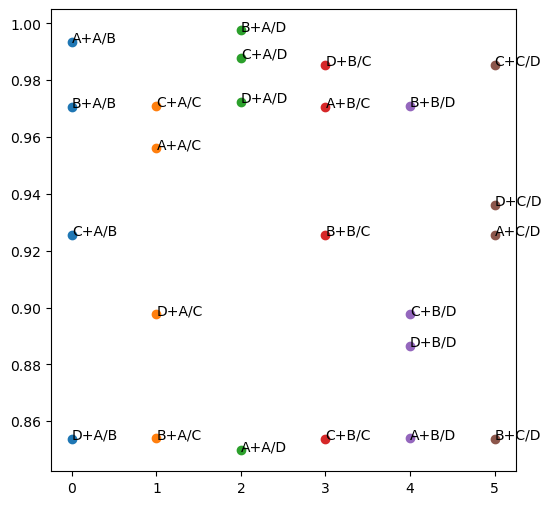

In [96]:
for i, j in enumerate(pses):
    plt.scatter(np.ones(len(j))*i, j)
    for jj,jval in enumerate(j):
        plt.annotate(nm[i*len(j)+jj], (i, jval))
    print(np.mean(j))

In [97]:
syms = ['A', 'B', 'C', 'D']
addends = list(range(4))
augends = list(itertools.combinations(addends, 2))

pses = []
nm = []
for aug in augends:
    ps_scores = []
    for addnd in addends:
        print(syms[aug[0]], '/', syms[aug[1]],'+', syms[addnd])
        nm.append(str(syms[aug[0]])+ '/'+ str(syms[aug[1]])+'+'+str(syms[addnd]))
        u = m[:, aug[0] + addnd]
        v = m[:, aug[1] + addnd]
        ps = np.dot(u,v)/np.linalg.norm(u)/np.linalg.norm(v)
        print('ps: ', ps)
        ps_scores.append(ps)
    pses.append(ps_scores)

A / B + A
ps:  0.9934293503359111
A / B + B
ps:  0.9707145691521597
A / B + C
ps:  0.9256227108680652
A / B + D
ps:  0.8538425660876441
A / C + A
ps:  0.9560156439550598
A / C + B
ps:  0.8539708231724589
A / C + C
ps:  0.9708538422205952
A / C + D
ps:  0.8975922387674539
A / D + A
ps:  0.8497896915369432
A / D + B
ps:  0.9975486485719282
A / D + C
ps:  0.987785808231387
A / D + D
ps:  0.972268711529993
B / C + A
ps:  0.9707145691521597
B / C + B
ps:  0.9256227108680652
B / C + C
ps:  0.8538425660876441
B / C + D
ps:  0.9854122839278796
B / D + A
ps:  0.8539708231724589
B / D + B
ps:  0.9708538422205952
B / D + C
ps:  0.8975922387674539
B / D + D
ps:  0.8864939854893943
C / D + A
ps:  0.9256227108680652
C / D + B
ps:  0.8538425660876441
C / D + C
ps:  0.9854122839278796
C / D + D
ps:  0.9361767293007011


0.935902299110945
0.9196081370288919
0.9518482149675628
0.9338980325089372
0.9022277224124755
0.9252635725460725


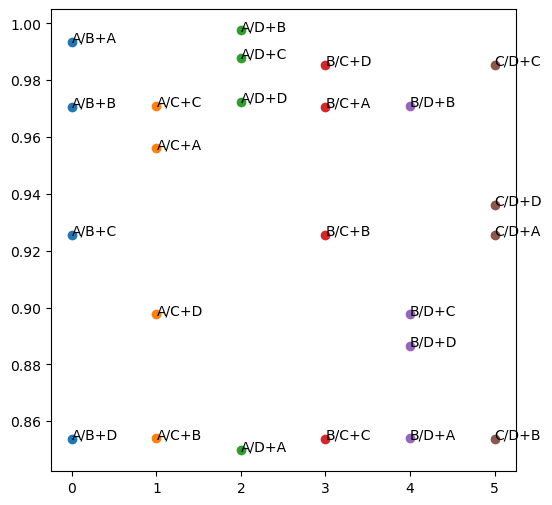

In [98]:
for i, j in enumerate(pses):
    plt.scatter(np.ones(len(j))*i, j)
    for jj,jval in enumerate(j):
        plt.annotate(nm[i*len(j)+jj], (i, jval))
    print(np.mean(j))

(array([6., 0., 1., 2., 0., 4., 0., 1., 5., 5.]),
 array([0.84978969, 0.86456559, 0.87934148, 0.89411738, 0.90889327,
        0.92366917, 0.93844507, 0.95322096, 0.96799686, 0.98277275,
        0.99754865]),
 <BarContainer object of 10 artists>)

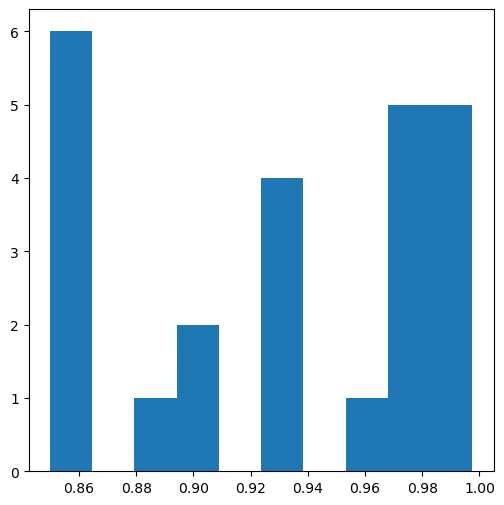

In [72]:
plt.hist(pses)

In [68]:
addnd = addends[3]

In [69]:
for aug in augends:
    print(addnd[0])
    print(syms[aug],'+', syms[addnd[0]], '/', syms[addnd[1]])
    u = m[:, aug + addnd[0]]
    v = m[:, aug + addnd[1]]
    ps = np.dot(u,v)/np.linalg.norm(u)/np.linalg.norm(v)
    print('ps: ', ps)

1
A + B / C
ps:  0.9707145691521597
1
B + B / C
ps:  0.9256227108680652
1
C + B / C
ps:  0.8538425660876441
1
D + B / C
ps:  0.9854122839278796


In [45]:
m.shape

AttributeError: 'tuple' object has no attribute 'shape'